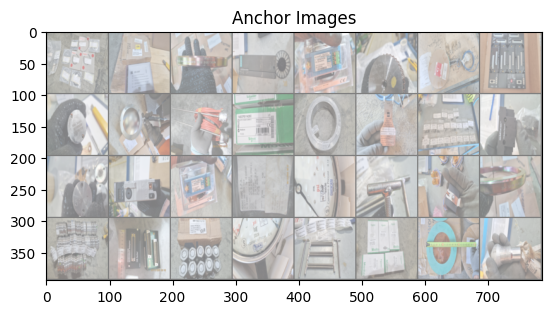

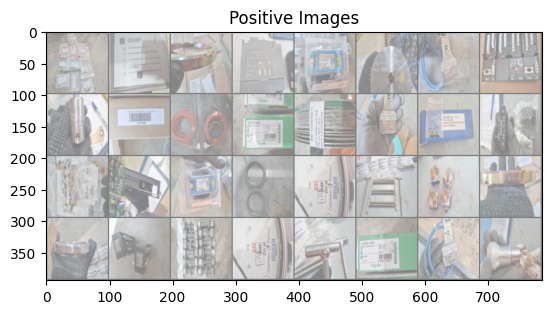

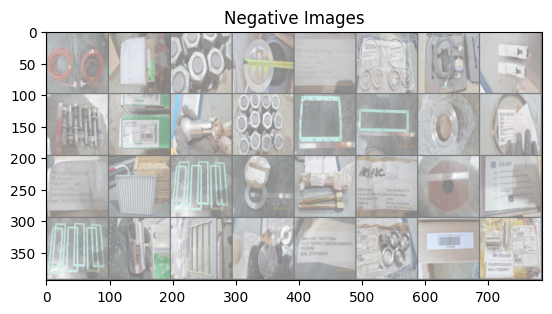

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
import random
import torchvision

train_data_path = '/workspaces/finetune/combined_classes'

class TinyImageNetDataset_Triplet(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = []
        self.class_images = {}  # To store images by class
        self._load_images()

    def _load_images(self):
        for idx, class_name in enumerate(os.listdir(self.path)):
            class_folder = os.path.join(self.path, class_name)
            if os.path.isdir(class_folder):
                self.class_to_idx[class_name] = idx
                self.idx_to_class.append(class_name)
                image_list = os.listdir(class_folder)
                if len(image_list) > 1:  # Only consider classes with more than one image
                    self.class_images[idx] = []
                    for image_name in image_list:
                        image_path = os.path.join(class_folder, image_name)
                        self.images.append((image_path, idx))
                        self.labels.append(idx)
                        self.class_images[idx].append(image_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        anchor_image_path, anchor_label = self.images[item]
        
        ###### Anchor Image #######
        anchor_img = Image.open(anchor_image_path).convert('RGB')

        ###### Positive Image #######
        positive_image_path = anchor_image_path
        while positive_image_path == anchor_image_path:
            positive_image_path = random.choice(self.class_images[anchor_label])
        positive_img = Image.open(positive_image_path).convert('RGB')
        
        ###### Negative Image #######
        negative_label = anchor_label
        while negative_label == anchor_label:
            negative_label = random.choice(list(self.class_images.keys()))
        negative_image_path = random.choice(self.class_images[negative_label])
        negative_img = Image.open(negative_image_path).convert('RGB')

        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label

# Example usage
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

def get_train_dataset(IMAGE_SIZE=96):
    train_dataset = TinyImageNetDataset_Triplet(
        path=train_data_path,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
        ])
    )
    return train_dataset

# Example usage
train_dataset = get_train_dataset()
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Visualize some samples
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training data
dataiter = iter(dataloader)
anchor_img, positive_img, negative_img, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(anchor_img), title='Anchor Images')
imshow(torchvision.utils.make_grid(positive_img), title='Positive Images')
imshow(torchvision.utils.make_grid(negative_img), title='Negative Images')


In [20]:
len(train_dataset[0][0][0][0])

96

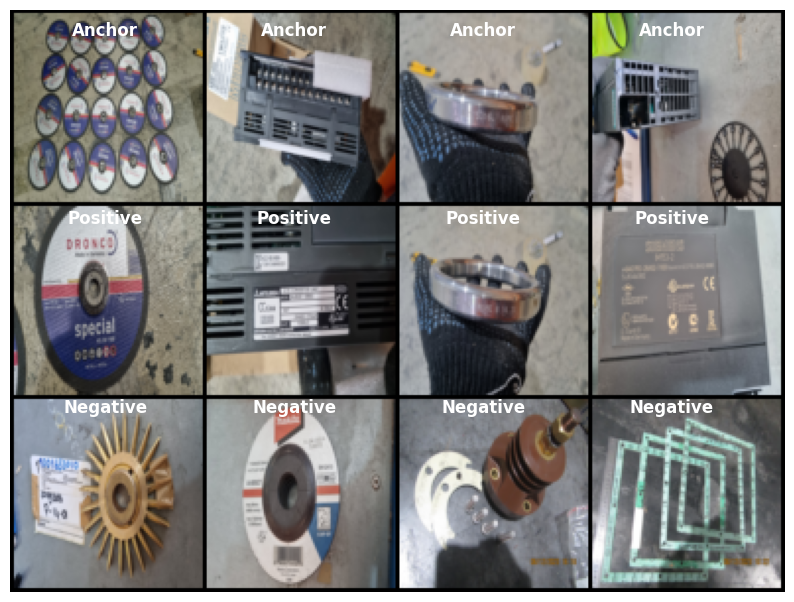

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Example usage
train_dataset = get_train_dataset()
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Visualize some samples
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training data
dataiter = iter(dataloader)
anchor_img, positive_img, negative_img, labels = next(dataiter)

# Arrange images into a grid
# We concatenate the images so that each row contains anchor, positive, and negative images for each sample
grid_img = torch.cat([anchor_img, positive_img, negative_img], dim=0)
grid = torchvision.utils.make_grid(grid_img, nrow=4)

# Display the grid
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(grid.numpy(), (1, 2, 0)))

# Add labels
for i in range(4):  # assuming batch size is 4
    ax.text(i * 96 + 48, 10, 'Anchor', ha='center', va='center', color='white', fontsize=12, weight='bold')
    ax.text(i * 96 + 48, 106, 'Positive', ha='center', va='center', color='white', fontsize=12, weight='bold')
    ax.text(i * 96 + 48, 202, 'Negative', ha='center', va='center', color='white', fontsize=12, weight='bold')

plt.axis('off')
plt.show()


In [3]:
from torch import nn

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    def calc_euclidean(self, x1, x2):
        return (x1-x2).pow(2).sum(1)
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [4]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


def get_default_device():
    """Pick GPU if available, else CPU."""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
                            

IMAGE_SIZE = 96
BATCH_SIZE = 4
DEVICE = get_default_device()
LEARNING_RATE = 0.005
EPOCHS = 10

In [5]:
train_dataset = get_train_dataset(IMAGE_SIZE = IMAGE_SIZE)
train_dl = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4,pin_memory=True)

In [24]:
class ResNet_Triplet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = resnet18(pretrained=True)
        num_filters = self.Feature_Extractor.fc.in_features
        self.Feature_Extractor.fc = nn.Sequential(
                  nn.Linear(num_filters,512),
                  nn.LeakyReLU(),
                  nn.Linear(512,10))
        self.Triplet_Loss = nn.Sequential(
                  nn.Linear(10,2))
    
    def forward(self,x):
        features = self.Feature_Extractor(x)
        triplets = self.Triplet_Loss(features)
        return triplets

    def get_embeddings(self, x):
        """Extract embeddings using the feature extractor."""
        return self.Feature_Extractor(x)

In [25]:
ResNet = ResNet_Triplet()
ResNet = ResNet.to(DEVICE)
Optimizer = torch.optim.Adam(ResNet.parameters(),lr = LEARNING_RATE)
criterion = TripletLoss()

/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
import torch
import numpy as np
from tqdm import tqdm

# Assuming DEVICE, EPOCHS, ResNet, criterion, and Optimizer are defined elsewhere in your code

# Define the training loop
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_dl, desc="Training", leave=False)):
        
        anchor_img = anchor_img.to(DEVICE)
        positive_img = positive_img.to(DEVICE)
        negative_img = negative_img.to(DEVICE)
        
        Optimizer.zero_grad()
        
        anchor_out = ResNet(anchor_img)
        positive_out = ResNet(positive_img)
        negative_out = ResNet(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        Optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
        
    print(f"Epoch: {epoch+1}/{EPOCHS} — Step: {step+1} — Loss: {np.mean(running_loss):.4f}")


Epochs:  10%|█         | 1/10 [01:00<09:04, 60.52s/it]

Epoch: 1/10 — Step: 122 — Loss: 2.2824


Epochs:  20%|██        | 2/10 [02:01<08:07, 60.98s/it]

Epoch: 2/10 — Step: 122 — Loss: 0.9641


Epochs:  30%|███       | 3/10 [03:02<07:05, 60.78s/it]

Epoch: 3/10 — Step: 122 — Loss: 0.9885


Epochs:  40%|████      | 4/10 [04:01<06:01, 60.29s/it]

Epoch: 4/10 — Step: 122 — Loss: 1.0145


Epochs:  50%|█████     | 5/10 [05:00<04:57, 59.59s/it]

Epoch: 5/10 — Step: 122 — Loss: 0.9986


Epochs:  60%|██████    | 6/10 [06:01<04:00, 60.08s/it]

Epoch: 6/10 — Step: 122 — Loss: 0.9890


Epochs:  70%|███████   | 7/10 [07:02<03:01, 60.43s/it]

Epoch: 7/10 — Step: 122 — Loss: 0.9669


Epochs:  80%|████████  | 8/10 [08:03<02:01, 60.68s/it]

Epoch: 8/10 — Step: 122 — Loss: 1.0170


Epochs:  90%|█████████ | 9/10 [09:05<01:00, 60.94s/it]

Epoch: 9/10 — Step: 122 — Loss: 1.0019


Epochs: 100%|██████████| 10/10 [10:06<00:00, 60.67s/it]

Epoch: 10/10 — Step: 122 — Loss: 0.9877


In [30]:
# Save the model state dictionary
torch.save(ResNet.state_dict(), 'resnet_triplet.pth')

In [32]:
# Load the model
model = ResNet_Triplet()
model.load_state_dict(torch.load('/workspaces/finetune/CNN/resnet_triplet.pth'))
model.to(DEVICE)
model.eval()


/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet_Triplet(
  (Feature_Extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [27]:
# To get embeddings from the trained model
def get_image_embedding(model, image_tensor):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        embedding = model.get_embeddings(image_tensor.to(DEVICE))
    return embedding

In [29]:


get_image_embedding(ResNet, train_dataset[0][0][0])

ResNet.save()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [96, 96]